## Project Description

With climate change the range of flora and fauna are changing. In particular, flat areas, such as those that typify grasslands, are very susceptible to changes in species range change because plants and animals will have to move over long distance to maintain suitable temperatures. Additionally, the water supply in these areas are increasingly stressed by higher evaporation and changing rainfall under warmer temperatures. 



## Study Areas

These two sites were chosen because of their positions within the current range of Sorghastrum nutan: Pawnee National Grassland is at the western edge of the current range while Cimarron National Grassland is surrounded by areas where S. nutan currently grows.


In [1]:
# Import libraries

import logging
import os
import shutil
import subprocess
import pathlib
from glob import glob
import math

import warnings
from IPython.display import display, HTML, Image
import earthpy as et
import earthpy.earthexplorer as etee
import earthpy.appeears as etapp
import folium
import geopandas as gpd
import geoviews as gv
import holoviews as hv
import hvplot.pandas
import hvplot.xarray
import keyring
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rioxarray as rxr
import requests
import xarray as xr
from xrspatial import aspect
import rioxarray.merge as rxrmerge

/Users/alexiemillikin/miniconda3/envs/earth-analytics-python/lib/python3.8/site-packages/geoviews/operation/__init__.py:14: HoloviewsDeprecationWarning: 'ResamplingOperation' is deprecated and will be removed in version 1.18, use 'ResampleOperation2D' instead.
  from holoviews.operation.datashader import (


In [2]:
# Set up logging so AppeearsDownloader will log in notebook
logging.basicConfig(level=logging.INFO)

# Ignore FutureWarning coming from hvplot
warnings.simplefilter(action='ignore', category=FutureWarning)

# Create path to SRTM elevation directory
srtm_dir = os.path.join(et.io.HOME, et.io.DATA_NAME, 'srtm')

# Create SRTM elevation directory
os.makedirs(srtm_dir, exist_ok=True)

In [3]:
# Define url for grassland boundary data
grasslands_url = (
    "https://data.fs.usda.gov/geodata/edw/edw_resources"
    "/shp/S_USA.NationalGrassland.zip"
)

# Load grassland boundary data, set index to grassland name,
# and reproject to same coordinate reference system as other data
grasslands_gdf = (
    gpd.read_file(grasslands_url)
    .set_index('GRASSLANDN')
    .to_crs(epsg=4326)
)

In [4]:
# Creata map of national grasslands

# Define coordinates of study areas for plotting
cim_lat = 37.139418
cim_lon = -101.7941457
paw_lat = 40.7614588
paw_lon = -104.0493284

# Create a Folium map object
grassland_map = folium.Map(
    location=[paw_lat, paw_lon],
    zoom_start=5,
    scrollWheelZoom=False
    )

# Create and add title to map
map_title = "National Grasslands Map"
title_html = (
    f'<h1 style="position:absolute;z-index:100000;left:30vw" >{map_title}</h1>')
grassland_map.get_root().html.add_child(folium.Element(title_html))

# Define style for grasslands outlines
grassland_style = {
    "fillColor": "maroon",
    "color": "black",
    "weight": 0.5,
}

# Convert the GeoDataFrame to GeoJSON format
grasslands_geojson = grasslands_gdf.to_json()

# Create separate feature groups for tile layers
esri_world_imagery_group = (
    folium
    .FeatureGroup(name='ESRI World Imagery', show=False)
)

# Add ESRI World Imagery as a Tile Layer
esri_world_imagery = folium.TileLayer(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services"
    "/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Esri",
    overlay=True,
).add_to(esri_world_imagery_group)

# Add feature groups to the map
esri_world_imagery_group.add_to(grassland_map)

# Add grassland boundaries to map as GeoJSON layer
folium.GeoJson(
    grasslands_geojson,
    name='National Grassland',
    style_function=lambda feature: grassland_style
    ).add_to(grassland_map)

# Add markers for study areas
folium.Marker(
    location=[cim_lat, cim_lon],
    popup='Cimarron National Grassland').add_to(grassland_map)

folium.Marker(
    location=[paw_lat, paw_lon],
    popup='Pawnee National Grassland').add_to(grassland_map)

# Add layer control to toggle between different layers
folium.LayerControl(collapsed=False).add_to(grassland_map)

# Display the map
grassland_map

In [5]:
# Select and save Cimarron boundary as own geodataframe
cim_gdf = (
    grasslands_gdf[grasslands_gdf.index == 'Cimarron National Grassland'])

# Select and save Pawnee boundary as own geodataframe
paw_gdf = (
    grasslands_gdf[grasslands_gdf.index == 'Pawnee National Grassland'])

Pawnee National Grassland is located in northeastern Colorado and spans 193,060 acres (40.7614588, -104.0493284). No rivers run through the grasslands but water is accessible in shallow aquifers. Shales and sandstones underly most of the grasslands, and sandstone make up the two Pawnee Buttes. Grasses dominate the vegetation although there are some shurbs and yucca and cottonwoods are present near springs. Elevation ranges from 4300 to 5900 feet. The average January high temperature is 44 °F and the average low is 17°F. Summers are hot and dry. July average high and low of 92 and 59°F, respectively. The annual precipitation is 18 inches and mostly falls in spring. The Pawnee National Grasslands are located on the ancestral homelands of the Cheyenne, Arapaho and Očhéthi Šakówiŋ peoples.

In [6]:
# Creata map for Pawnee National Grassland

# Define coordinates of study area for plotting
paw_lat = 40.7614588
paw_lon = -104.0493284

# Create a Folium map object
pawnee_map = folium.Map(
    location=[paw_lat, paw_lon],
    zoom_start=10,
    scrollWheelZoom=False
    )

# Create and add title to map
map_title = "Pawnee National Grassland Map"
title_html = (
    f'<h1 style="position:absolute;z-index:100000;left:30vw" >{map_title}</h1>')
pawnee_map.get_root().html.add_child(folium.Element(title_html))

# Define style for grasslands outlines
grassland_style = {
    "fillColor": "maroon",
    "color": "black",
    "weight": 0.5,
}

# Convert the GeoDataFrame to GeoJSON format
paw_geojson = paw_gdf.to_json()

# Create feature group for tile layers
esri_world_imagery_group = (
    folium.FeatureGroup(name='ESRI World Imagery', show=False)
)

# Add ESRI World Imagery as a Tile Layer
esri_world_imagery = folium.TileLayer(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services"
    "/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Esri",
    overlay=True,
).add_to(esri_world_imagery_group)

# Add feature group to the map
esri_world_imagery_group.add_to(pawnee_map)

# Add the Pawnee boundary data to the map as a GeoJson layer
folium.GeoJson(
    paw_geojson,
    name='National Grassland',
    style_function=lambda feature: grassland_style
    ).add_to(pawnee_map)

# Add layer control to toggle between different layers
folium.LayerControl(collapsed=False).add_to(pawnee_map)

# Display the map
pawnee_map

Cimarron National Grassland is located in southwestern Kansas (37.139418, -101.7941457) and covers 108,175 acres. The landscape comprises sandstone and limestone cliffs with shale bedrock underlying low lying areas. Vegetation includes cottonwoods, prairie grasses, yucca and sagebrush. The elevation ranges from 3,150 to 3,540 feet. The Cimarron River provides water to the area and flows through the grasslands but is usually dry above ground late summer through winter. Winter climate is mild to cold with little snowfall. The average January high temperature is 48 °F and the average low is 21°F. Summers are hot and dry, with a July average high and low of 94 and 65°F, respectively. The annual precipitation is 15 inches and mostly falls from spring to early fall. The Cimarron National Grasslands are located on the ancestral homelands of the Kiowa, Kansa, Osage, Pawnee, Comanche, Očhéthi Šakówiŋ, Arapaho, and Ute peoples.

In [7]:
# Define coordinates of study area for plotting
cim_lat = 37.139418
cim_lon = -101.7941457

# Create a Folium map object
cim_map = folium.Map(
    location=[cim_lat, cim_lon],
    zoom_start=10,
    scrollWheelZoom=False
    )

# Create and add title to map
map_title = "Cimarron National Grassland Map"
title_html = (
    f'<h1 style="position:absolute;z-index:100000;left:30vw" >{map_title}</h1>')
cim_map.get_root().html.add_child(folium.Element(title_html))

# Define style for grasslands outlines
grassland_style = {
    "fillColor": "maroon",
    "color": "black",
    "weight": 0.5,
}

# Convert the GeoDataFrame to GeoJSON format
cim_geojson = cim_gdf.to_json()

# Create separate feature groups for tile layers
esri_world_imagery_group = (
    folium.FeatureGroup(name='ESRI World Imagery', show=False)
)

# Add ESRI World Imagery as a Tile Layer
esri_world_imagery = folium.TileLayer(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services"
    "/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Esri",
    overlay=True,
).add_to(esri_world_imagery_group)

# Add feature groups to the map
esri_world_imagery_group.add_to(cim_map)

# Add grassland boundary to map as GeoJSON layer
folium.GeoJson(
    cim_geojson,
    name='National Grassland',
    style_function=lambda feature: grassland_style
    ).add_to(cim_map)

# Add layer control to toggle between different layers
folium.LayerControl(collapsed=False).add_to(cim_map)

# Display the map
cim_map

## POLARIS dataset:
The POLARIS dataset is a 30m spatial resolution predicted soil map of the United States that contains over 9 billion grid cells. The map was constructed by combing environmental data and a machine learning algorithm and is an improvement over it’s predecessor, the Soil Survey Geographic (SSURGO) database, in that uses predictive modelling to fill in unmapped areas. This dataset includes a number of soil variables, including percentage of silt, sand and clay, bulk density, soil water content, soil pH, organic matter content, and measures of pore size. In this analysis we usemean  pH daa from 60-100 cm depth. This depth was used because it is about half the maximum root depth of S. nutans (Macleod, 2017).a

### POLARIS citation:
Chaney, N. W., Wood, E. F., McBratney, A. B., Hempel, J. W., Nauman, T. W., Brungard, C. W., & Odgers, N. P. (2016). POLARIS: A 30-meter probabilistic soil series map of the contiguous United States. Geoderma, 274, 54-67.


In [76]:
# Define function to get the bounds of a grassland
def calculate_bounds(gdf):
    """
    Calculates the bounds for data download from POLARIS dataset given a gdf.

    Parameters
    ==========
    gdf : gdf
      Input geodataframe

    Returns
    =======
    east_bound : int
      longitude integer to east of eastern-most point in geodataframe
    south_bound : int
      longitude integer to south of southern-most point in geodataframe
    west_bound : int
      longitude integer to west of western-most point in geodataframe
    north_bound : int
      longitude integer to north of northern-most point in geodataframe
    """
    max_lon, min_lat, min_lon, max_lat = map(abs, gdf.total_bounds)
    east_bound = math.floor(min_lon)
    south_bound = math.floor(min_lat)
    west_bound = math.ceil(max_lon)
    north_bound = math.ceil(max_lat)
    return east_bound, south_bound, west_bound, north_bound

In [17]:
# Create list of two grasslands
two_grasslands_gdf = [cim_gdf, paw_gdf]

# Define name for each dataframe to make variables
cim_gdf.name = "cim"
paw_gdf.name = "paw"

# Execute function to create variables for bounds of grasslands
for gdf in two_grasslands_gdf:
    east_bound, south_bound, west_bound, north_bound = calculate_bounds(gdf)

    # Use globals() to create global variables dynamically
    globals()[f"{gdf.name}_east_bound"] = east_bound
    globals()[f"{gdf.name}_south_bound"] = south_bound
    globals()[f"{gdf.name}_west_bound"] = west_bound
    globals()[f"{gdf.name}_north_bound"] = north_bound

# Access bounding varibales
# cim_north_bound

In [23]:
def generate_pH_urls(south_bound, north_bound, east_bound, west_bound):
    """
    Creates urls for data download from POLARIS dataset: mean pH from 60-100cm depth.

    Data citation:
    Chaney, N. W., Wood, E. F., McBratney, A. B., Hempel, J. W., Nauman, T. W.,
    Brungard, C. W., & Odgers, N. P. (2016).
    POLARIS: A 30-meter probabilistic soil series map of the contiguous United States.
    Geoderma, 274, 54-67.

    Parameters
    ==========
    south_bound : int
      longitude integer to south of southern-most point in geodataframe
    north_bound : int
      longitude integer to north of northern-most point in geodataframe
    east_bound : int
      longitude integer to east of eastern-most point in geodataframe
    west_bound : int
      longitude integer to west of western-most point in geodataframe

    Returns
    =======
    ph_urls : list of str variables
      list of urls to use for data downloads
    """
    pH_urls = []

    for lat in range(south_bound, north_bound):
        for lon in range(east_bound + 1, west_bound + 1):
            url = f"http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/60_100/lat{lat}{lat + 1}_lon-{lon}-{lon-1}.tif"
            pH_urls.append(url)

    return pH_urls

In [24]:
# Run generate_pH_urls function on gdf for each grassland to create url list for download
cim_ph_urls = generate_pH_urls(cim_south_bound, cim_north_bound, cim_east_bound, cim_west_bound)
paw_ph_urls = generate_pH_urls(paw_south_bound, paw_north_bound, paw_east_bound, paw_west_bound)

In [20]:
# Download, merge and clip pH data for each grassland
# Download pH data from each grassland's url list
cim_pH_das = [rxr.open_rasterio(url, masked=True).squeeze() for url in cim_ph_urls]
paw_pH_das = [rxr.open_rasterio(url, masked=True).squeeze() for url in paw_ph_urls]

# Merge pH data into one data array for each grassland
cim_merged_pH_da = rxrmerge.merge_arrays(cim_pH_das)
paw_merged_pH_da = rxrmerge.merge_arrays(paw_pH_das)

# Clip the raster data to the bounds of grassland
cim_bound_box = cim_gdf.total_bounds
cim_clipped_pH_da = cim_merged_pH_da.rio.clip_box(*cim_bound_box)

paw_bound_box = paw_gdf.total_bounds
paw_clipped_pH_da = paw_merged_pH_da.rio.clip_box(*paw_bound_box)

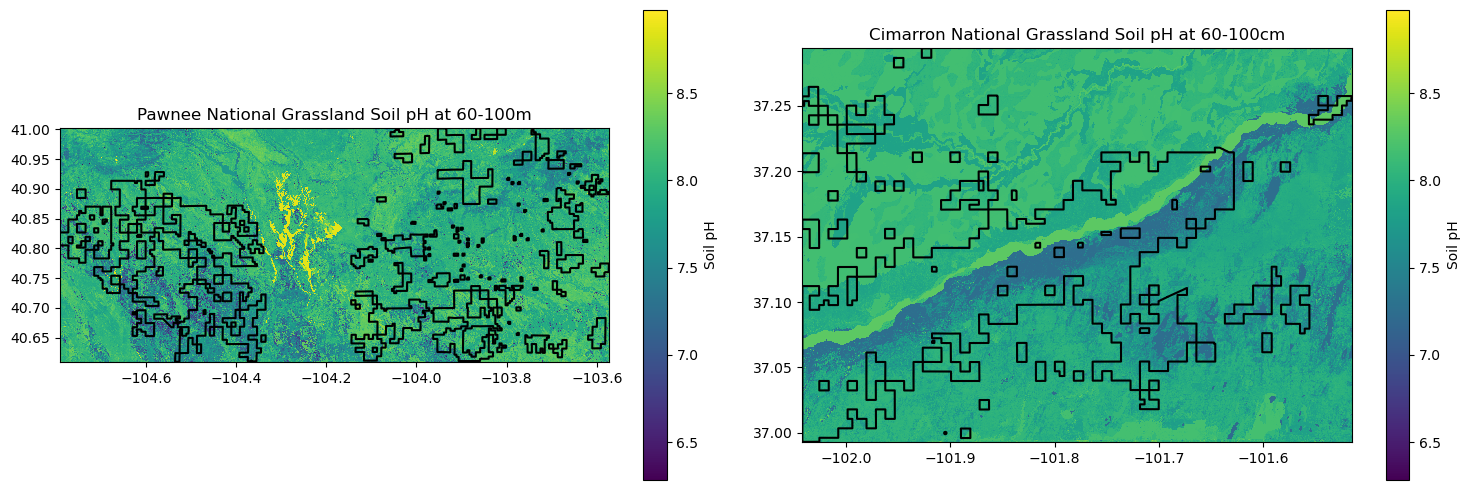

In [37]:
# Plot pH data from both grasslands
# Initialize pH figure
plt.figure(figsize=(15, 5))

# Plot the Pawnee pH data
plt.subplot(1, 2, 1)
imshow_obj_pawnee = paw_clipped_pH_da.plot(cmap='viridis', ax=plt.gca(), add_colorbar=False)
plt.title('Pawnee National Grassland Soil pH at 60-100m')
plt.xlabel('')
plt.ylabel('')
pawnee_colorbar = plt.colorbar(imshow_obj_pawnee, label='Soil pH')
paw_gdf.boundary.plot(ax=plt.gca(), color='black', linewidth=1.5)

# Plot the Cimarron pH data
plt.subplot(1, 2, 2)
imshow_obj_cimarron = cim_clipped_pH_da.plot(cmap='viridis', ax=plt.gca(), add_colorbar=False)
plt.title('Cimarron National Grassland Soil pH at 60-100cm')
plt.xlabel('')
plt.ylabel('')
cimarron_colorbar = plt.colorbar(imshow_obj_cimarron, label='Soil pH')
cim_gdf.boundary.plot(ax=plt.gca(), color='black', linewidth=1.5)

# Set the colorbar limits to be the same for both plots
min_value = min(paw_clipped_pH_da.min(), cim_clipped_pH_da.min())
max_value = max(paw_clipped_pH_da.max(), cim_clipped_pH_da.max())
pawnee_colorbar.mappable.set_clim(min_value, max_value)
cimarron_colorbar.mappable.set_clim(min_value, max_value)

plt.tight_layout()
plt.show()

## SRTM elevation dataset:


 he Shuttle Radar Topography Mission (SRTM) elevation dataset is near-global set of land elevations, combinging data grom 80% of Earth’s land surface between 60° north and 56° south. SRTM was undertaken on the Endeavor space shuttle in February of 2000 as a collaboration between the National Aeronautics and Space Administration (NASA) and the National Geospatial-Intelligence Agency (NGA). Radar images were taken using  C-band Spaceborne Imaging Radar and the X-Band Synthetic Aperture Radar (X-SAR) hardware, which acquired two signals at slightly different angles different radar antennas—one attached to the shuttle and the other attached to a 60m mast—that enabled surface elevation calculation by computing the difference between the two signals. Data were measured every ~30meters, and displayed in units of meters. In this analysis slope and slope aspect are calculated from this digital elevation model (DEM). Data were accessed through NASA’s Application for Extracting and Exploring Analysis Ready Samples (AppEEARS)

### SRTM citation:on:
NASA JPL (2013). NASA Shuttle Radar Topography Mission Global 1 arc second [Data set]. NASA EOSDIS Land Processes Distributed Active Archive Center. Accessed 2023-12-05 from https://doi.org/10.5067/MEaSUREs/SRTM/SRTMGL1.003


In [45]:
# Create function for downloading data
def download_srtm_data(ea_dir, download_key, product, layer, start_date, end_date, polygon):
    """
    Download SRTM raster elevation data for a given geometry, start date, and end date.

    Data citation:
    NASA JPL (2013). NASA Shuttle Radar Topography Mission Global 1 arc second [Data set].
    NASA EOSDIS Land Processes Distributed Active Archive Center.
    Accessed 2023-12-11 from https://doi.org/10.5067/MEaSUREs/SRTM/SRTMGL1.003

    Data downloaded from NASA AρρEEARS

    Parameters
    ==========
    ea_dir : str
      path to directory where data will be saved
    download_key : str
      The name used to label the download
    product : str
      Data product to download NASA Shuttle Radar Topography Mission Global 1 arc second
    layer : str
      Digital elevation data (DEM) layer to download (meters)
    start_date : str
      The start date as 'MM-DD-YYYY'
    end_date : str
      The end date as 'MM-DD-YYYY'
    polygon : gdf
      Bounds for data donwload

    Returns
    =======
    downloader : earthpy.AppearsDownloader
      Object with information about the download.
    """

    data_dir = os.path.join(ea_dir, download_key)  # Define the data directory path

    # Check if the download directory exists
    if not os.path.exists(data_dir):
        # If it doesn't exist, create the directory and download files
        os.makedirs(data_dir)

        # Define parameters for data download
        elev_downloader = etapp.AppeearsDownloader(
            ea_dir=ea_dir,
            download_key=download_key,
            product=product,
            layer=layer,
            start_date=start_date,
            end_date=end_date,
            polygon=polygon,
        )

    # Download files
        elev_downloader.download_files()

    else:
        print(f"Data already exists in {data_dir}. Skipping download.")

# Set parameters for srtm elevation download
srtm_dir = srtm_dir
product = "SRTMGL1_NC.003"
layer = "SRTMGL1_DEM"
start_date = "02-11-2000"
end_date = "02-21-2000"
paw_download_key = "pawnee-srtm"
cim_download_key = "cimarron-srtm"

In [43]:
# Download DEM data for each grassland
download_srtm_data(srtm_dir, paw_download_key, product, layer, start_date, end_date, paw_gdf)
download_srtm_data(srtm_dir, cim_download_key, product, layer, start_date, end_date, cim_gdf)

Data already exists in /Users/alexiemillikin/earth-analytics/data/srtm/pawnee-srtm. Skipping download.
Data already exists in /Users/alexiemillikin/earth-analytics/data/srtm/cimarron-srtm. Skipping download.


In [63]:
# Process SRTM data to extrct elevation data
# Create list of download keys to iterate through data directory paths
download_keys = [paw_download_key, cim_download_key]

# Initialize dictionary for srtm data
all_srtm_data = {}

# Iterate through downloaded data to create
for download_key in download_keys:

    # Create file paths to all .tif files
    srtm_paths = glob(
        os.path.join(srtm_dir, download_key, 'SRTMGL1_NC.003*', '*.tif')
    )

    # # Open all raster data and save in list
    srtm_data = [rxr.open_rasterio(srtm_path, masked=True).squeeze() for srtm_path in srtm_paths]

    # Open first element of srtm_data list which contains elevation data
    # Set coordinate reference system
    with rxr.open_rasterio(srtm_paths[0]) as src:
        srtm_data[0].attrs['crs'] = src.rio.crs

    # Save SRTM data in all_srtm_data dictionary
    all_srtm_data[download_key] = srtm_data


# Save elevation DataArrays using the download keys to call element from dictionary
paw_srtm_data = all_srtm_data[paw_download_key][0]
cim_srtm_data = all_srtm_data[cim_download_key][0]

In [65]:
# Clip elevation data to grassland gdf
cim_srtm_data_clip = cim_srtm_data.rio.clip_box(*cim_bound_box)
paw_srtm_data_clip = paw_srtm_data.rio.clip_box(*paw_bound_box)

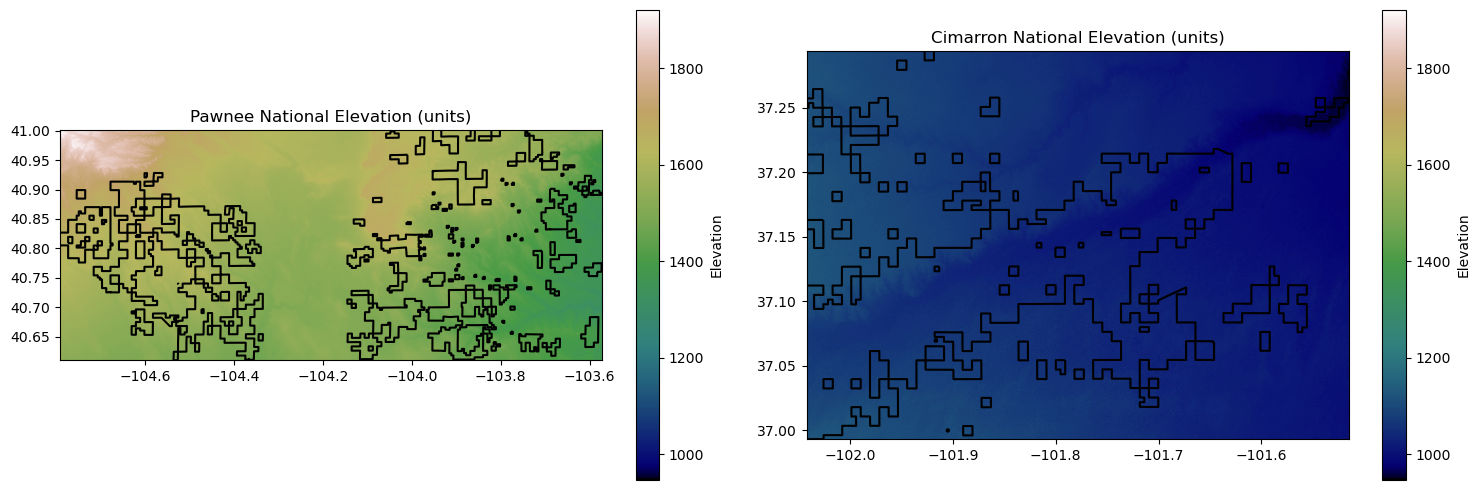

In [75]:
# Initialize plot for elevation data
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot Pawnee elevation data
imshow_obj_pawnee = paw_srtm_data_clip.plot(cmap='gist_earth', ax=axs[0], add_colorbar=False)
pawnee_colorbar = plt.colorbar(imshow_obj_pawnee, ax=axs[0], label='Elevation')
axs[0].set_title('Pawnee National Elevation (units)')
paw_gdf.boundary.plot(ax=axs[0], color='black', linewidth=1.5)
axs[0].set_xlabel('')
axs[0].set_ylabel('')

# Plot Cimarron elevation data
imshow_obj_cimarron = cim_srtm_data_clip.plot(cmap='gist_earth', ax=axs[1], add_colorbar=False)
cimarron_colorbar = plt.colorbar(imshow_obj_cimarron, ax=axs[1], label='Elevation')
axs[1].set_title('Cimarron National Elevation (units)')
cim_gdf.boundary.plot(ax=axs[1], color='black', linewidth=1.5)
axs[1].set_xlabel('')
axs[1].set_ylabel('')

# Set the colorbar limits to be the same for both plots
min_value = min(paw_srtm_data_clip.min(), cim_srtm_data_clip.min())
max_value = max(paw_srtm_data_clip.max(), cim_srtm_data_clip.max())
pawnee_colorbar.mappable.set_clim(min_value, max_value)
cimarron_colorbar.mappable.set_clim(min_value, max_value)

plt.tight_layout()
plt.show()

## MACAv2 dataset:

The MACA dataset downscales modeled output of many climate variables (temperature, precipitation, humidity, wind, radiation) to a 4km resolution over the continental US. Model outputs come from 20 global climate models (GCMs) that were included in the Coupled Model Inter-Comparison Project 5 (CMIP5) and include historical forcings (1950-2005), and the Representative Concentation Pathways (RCPs) for 2006-2100: RCP 4.5, the low emissions scenario is representative of significant reduction in green house gas emissions, and RCP 8.5, the high emissions scenario. In this study I compare monthly average of daily maximum near-surface air temperature and precipitation for 1980 with projections for 2050 and 2099 for each of these climate scenarios. Model data used are from MRI-CGCM3, which was chosen because of it's ability to accuratley simulate historical North American climate (Radić & Clarke, 2011). Precipitation is calculated as the monthly aggregate of daily average precipitation in mm and summed for each year chosen. Maximum temperature is calculated as the monthly-aggregated maximum daily near surface temperature measured in degrees Kelvin, and is averaged for each year.

### MACAv2 citation:

Climate forcings in the MACAv2-METDATA were drawn from a statistical downscaling of global climate model (GCM) data from the Coupled Model Intercomparison Project 5 (CMIP5, Taylor et al. 2010) utilizing a modification of the Multivariate Adaptive Constructed Analogs (MACA, Abatzoglou and Brown, 2012) method with the METDATA (Abatzoglou, 2011) observational dataset as training data.

### MRI-CGCM3 citation:
Yukimoto, S., Adachi, Y., Hosaka, M., Sakami, T., Yoshimura, H., Hirabara, M., ... & Kitoh, A. (2012). A new global climate model of the Meteorological Research Institute: MRI-CGCM3—Model description and basic performance—. 気象集誌. 第 2 輯, 90(0), 23-64.



In [129]:
# Define url for historical precipitation data
hist_precip_url = (
    "http://thredds.northwestknowledge.net:8080/thredds/ncss"
    "/agg_macav2metdata_pr_MRI-CGCM3_r1i1p1_historical_1950_2005_CONUS_monthly.nc"
    "?var=precipitation&disableLLSubset=on&disableProjSubset=on&horizStride=1"
    "&time_start=1980-01-15T00%3A00%3A00Z"
    "&time_end=1980-12-15T00%3A00%3A00Z&timeStride=1&accept=netcdf"
)

# Download historical precipitation data
maca_response = requests.get(hist_precip_url)
with open('maca.nc', 'wb') as maca_file:
    maca_file.write(maca_response.content)

# Open the NetCDF file and process
maca_ds = xr.open_dataset('maca.nc')
maca_ds = maca_ds.assign_coords(lon=maca_ds.lon-360)
hist_precip_da = maca_ds.precipitation
hist_precip_da.rio.write_crs("epsg:4326", inplace=True)
hist_precip_da.rio.set_spatial_dims('lon', 'lat', inplace=True)

# Clip historical tmax data to grasslands
cim_hist_precip_da = hist_precip_da.rio.clip_box(*cim_gdf.total_bounds)
paw_hist_precip_da = hist_precip_da.rio.clip_box(*paw_gdf.total_bounds)

In [137]:
# Define url for historical max temperature data
hist_tmax_url = (
    "http://thredds.northwestknowledge.net:8080/thredds/ncss"
    "/agg_macav2metdata_tasmax_MRI-CGCM3_r1i1p1_historical_1950_2005_CONUS_monthly.nc"
    "?var=air_temperature&disableLLSubset=on&disableProjSubset=on&horizStride=1"
    "&time_start=1980-01-15T00%3A00%3A00Z"
    "&time_end=1980-12-15T00%3A00%3A00Z&timeStride=1&accept=netcdf"
)

# Download historical max temperature data
maca_response = requests.get(hist_tmax_url)
with open('maca.nc', 'wb') as maca_file:
    maca_file.write(maca_response.content)

# Open the NetCDF file and process
maca_ds = xr.open_dataset('maca.nc')
maca_ds = maca_ds.assign_coords(lon=maca_ds.lon-360)
hist_tmax_da = maca_ds.air_temperature - 273.15
hist_tmax_da.rio.write_crs("epsg:4326", inplace=True)
hist_tmax_da.rio.set_spatial_dims('lon', 'lat', inplace=True)

# Clip historical tmax data to grasslands
cim_hist_tmax_da = hist_tmax_da.rio.clip_box(*cim_gdf.total_bounds)
paw_hist_tmax_da = hist_tmax_da.rio.clip_box(*paw_gdf.total_bounds)

In [114]:
# Download and proccess future precipitation data
# Define future climate scenarios and model years
climate_scenarios = ['rcp45_2006_2099', 'rcp85_2006_2099']
abbrev_climate_scenarios = ['r45', 'r85']
years = ['2050', '2099']

# Create lists for urls
future_precip_urls = []

# Create an empty dictionary to store precip_dataarrays
precip_dataarrays = {}

# Loop through each climate scenario
for climate_scenario, abbrev_climate_scenario in zip(climate_scenarios, abbrev_climate_scenarios):
    # Loop through each year for the current climate scenario
    for year in years:
        # Construct the URL for the current combination of scenario and year
        precip_url = f"http://thredds.northwestknowledge.net:8080/thredds/ncss/agg_macav2metdata_pr_MRI-CGCM3_r1i1p1_{climate_scenario}_CONUS_monthly.nc?var=precipitation&disableLLSubset=on&disableProjSubset=on&horizStride=1&time_start={year}-01-15T00%3A00%3A00Z&time_end={year}-12-15T00%3A00%3A00Z&timeStride=1&accept=netcdf"

        # Download precipitation data
        filename = f'precip_{climate_scenario}_{year}.nc'
        precip_response = requests.get(precip_url)
        with open(filename, 'wb') as precip_file:
            precip_file.write(precip_response.content)

        # Open the NetCDF file
        precip_ds = xr.open_dataset(filename)
        precip_ds = precip_ds.assign_coords(lon=precip_ds.lon-360)
        precip_da = precip_ds.precipitation
        precip_da.rio.write_crs("epsg:4326", inplace=True)
        precip_da.rio.set_spatial_dims('lon', 'lat', inplace=True)

        # Store the DataArray in the dictionary with a key based on scenario and year
        key = f"{abbrev_climate_scenario}_{year}"
        precip_dataarrays[key] = precip_da

        # Close the dataset to release resources
        precip_ds.close()

# Access the DataArrays stored in the dictionary
# for key, precip_da in precip_dataarrays.items():
#     print(f"DataArray for {key}:\n{precip_da}")

In [146]:
# Create empty dictionaries to store clipped DataArrays
cim_precip_dataarrays = {}
paw_precip_dataarrays = {}

# Loop through each DataArray in the dictionary
for key, precip_da in precip_dataarrays.items():
    # Clip to cim_gdf
    cim_clipped_da = precip_da.rio.clip(cim_gdf.geometry, cim_gdf.crs)

    # Clip to paw_gdf
    paw_clipped_da = precip_da.rio.clip(paw_gdf.geometry, paw_gdf.crs)

    # Store the clipped DataArrays in the dictionaries
    cim_precip_dataarrays[key] = cim_clipped_da
    paw_precip_dataarrays[key] = paw_clipped_da

# Access the clipped DataArrays stored in the dictionaries
# for key, cim_clipped_da in cim_precip_dataarrays.items():
#     print(f"Clipped DataArray for {key} (Cimarron):\n{cim_clipped_da}")

# for key, paw_clipped_da in paw_precip_dataarrays.items():
#     print(f"Clipped DataArray for {key} (Pawnee):\n{paw_clipped_da}")

In [115]:
# Download and proccess future temperature data
# Create lists for urls
future_max_t_urls = []

# Create an empty dictionary to store precip_dataarrays
tmax_dataarrays = {}

# Loop through each climate scenario
for climate_scenario, abbrev_climate_scenario in zip(climate_scenarios, abbrev_climate_scenarios):
    # Loop through each year for the current climate scenario
    for year in years:
        # Construct the URL for the current combination of scenario and year
        tmax_url = f"http://thredds.northwestknowledge.net:8080/thredds/ncss/agg_macav2metdata_tasmax_MRI-CGCM3_r1i1p1_{climate_scenario}_CONUS_monthly.nc?var=air_temperature&disableLLSubset=on&disableProjSubset=on&horizStride=1&time_start={year}-01-15T00%3A00%3A00Z&time_end={year}-12-15T00%3A00%3A00Z&timeStride=1&accept=netcdf"

        # Download max temperature data
        filename = f'tmax_{climate_scenario}_{year}.nc'
        tmax_response = requests.get(tmax_url)
        with open(filename, 'wb') as tmax_file:
            tmax_file.write(tmax_response.content)

        # Open the NetCDF file
        tmax_ds = xr.open_dataset(filename)
        tmax_ds = tmax_ds.assign_coords(lon=tmax_ds.lon-360)
        tmax_da = tmax_ds.air_temperature
        tmax_da.rio.write_crs("epsg:4326", inplace=True)
        tmax_da.rio.set_spatial_dims('lon', 'lat', inplace=True)

        # Store the DataArray in the dictionary with a key based on scenario and year
        key = f"{abbrev_climate_scenario}_{year}"
        tmax_dataarrays[key] = tmax_da

        # Close the dataset to release resources
        tmax_ds.close()

# Access the DataArrays stored in the dictionary
# for key, tmax_da in tmax_dataarrays.items():
#     print(f"DataArray for {key}:\n{tmax_da}")

In [147]:
# Create empty dictionaries to store clipped DataArrays
cim_tmax_dataarrays = {}
paw_tmax_dataarrays = {}

# Loop through each DataArray in the dictionary
for key, tmax_da in tmax_dataarrays.items():
    # Clip to cim_gdf
    cim_clipped_da = tmax_da.rio.clip(cim_gdf.geometry, cim_gdf.crs)

    # Clip to paw_gdf
    paw_clipped_da = tmax_da.rio.clip(paw_gdf.geometry, paw_gdf.crs)

    # Store the clipped DataArrays in the dictionaries
    cim_tmax_dataarrays[key] = cim_clipped_da
    paw_tmax_dataarrays[key] = paw_clipped_da

# Access the clipped DataArrays stored in the dictionaries
# for key, cim_clipped_da in cim_tmax_dataarrays.items():
#     print(f"Clipped DataArray for {key} (Cimarron):\n{cim_clipped_da}")

# for key, paw_clipped_da in paw_tmax_dataarrays.items():
#     print(f"Clipped DataArray for {key} (Pawnee):\n{paw_clipped_da}")

In [122]:
# Plot the mean of one of the DataArrays
selected_key = 'r85_2050'  # Adjust the key based on your requirements
selected_precip_da = tmax_dataarrays[selected_key]

# Plot the mean of the DataArray using Holoviews
plot = selected_precip_da.mean('time').hvplot(rasterize=True)

plot

:DynamicMap   []
   :Image   [lon,lat]   (air_temperature)

In [142]:
# maca_ds = xr.open_dataset('maca.nc')
# maca_ds = maca_ds.assign_coords(lon=maca_ds.lon-360)
# hist_precip_da = maca_ds.precipitation
# hist_precip_da.rio.write_crs("epsg:4326", inplace=True)
# hist_precip_da.rio.set_spatial_dims('lon', 'lat', inplace=True)

cim_hist_precip_da.mean('time').hvplot(rasterize=True)

:DynamicMap   []
   :Image   [lon,lat]   (precipitation)

In [136]:
cim_hist_precip_da.rio.clip_box(*cim_gdf.total_bounds).mean('time').hvplot()*cim_gdf.hvplot()

:Overlay
   .Image.I    :Image   [lon,lat]   (precipitation)
   .Polygons.I :Polygons   [x,y]

## References Cited:



Macleod, C. (2017, January). Sorghastrum nutans, Indian Grass – 4 (4). North American Native Plant Society. https://nanps.org/native_plants_know/sorghastrum-nutans-indian-grass-4-4/#:~:text=Reaching%20depths%20of%20two%20metres,like%20seed%20heads%20called%20panicles

Radić, V., & Clarke, G. K. (2011). Evaluation of IPCC models’ performance in simulating late-twentieth-century climatologies and weather patterns over North America. Journal of climate, 24(20), 5257-5274.
